## AIRBNB SINGAPORE DATASET

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install langdetect

     |████████████████████████████████| 981 kB 13.2 MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993242 sha256=204d1c7a51bf2c76b71359efa9bb9522c66ec5a352434deb6d94fad81dd36542
  Stored in directory: /root/.cache/pip/wheels/c5/96/8a/f90c59ed25d75e50a8c10a1b1c2d4c402e4dacfa87f3aff36a
Successfully built langdetect


We are using two dataset in this project 1. airbnb listings and  2. Reviews on the airbnb for text analysis.

In [ ]:
#Import Python Libraries
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import shapiro
# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from plotnine import *
from statsmodels.graphics.gofplots import qqplot
import datetime
from textblob import TextBlob
# needed for the library to work in Google Colab
import nltk
nltk.download('punkt')

nltk.download('stopwords')
from nltk.corpus import stopwords

from wordcloud import WordCloud
import re
from langdetect import detect

%matplotlib inline


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#Read the dataset 1 airbnb listing
df1 = pd.read_csv("/content/drive/MyDrive/Dataset/Airbnb listing.csv")

In [ ]:
df1.columns

Index(['id', 'name', 'host_id', 'host_name', 'host_since', 'host_is_superhost',
       'host_listings_count', 'host_total_listings_count', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'zipcode',
       'country', 'latitude', 'longitude', 'property_type', 'room_type',
       'bed_type', 'amenities', 'price', 'weekly_price', 'monthly_price',
       'extra_people', 'minimum_nights', 'maximum_nights', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'number_of_reviews', 'first_review', 'last_review',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'requires_license', 'license',
       'instant_bookable', 'is_business_travel_ready',
       'require_guest_profile_picture', 'require_guest_phone_verification',
       'calculated_host_l

In [ ]:
print("The dataset has {} rows and {} columns.".format(*df1.shape))


The dataset has 8293 rows and 51 columns.


In [ ]:
# read dataset 2 reviews for text analysis
df2=pd.read_csv("/content/drive/MyDrive/Dataset/Reviews_Airbnb.csv")

In [ ]:
print("The dataset has {} rows and {} columns.".format(*df2.shape))


The dataset has 100919 rows and 6 columns.


Merging the two dataset we will take all the column of df2 i.e. Reviews and some columns form df1 i.e. listings of airbnb

In [ ]:
# merging full df2 + add only specific columns from df1
airbnb = pd.merge(df2, df1[['neighbourhood_group_cleansed', 'neighbourhood_cleansed','host_id', 'latitude',
                          'longitude', 'number_of_reviews', 'id', 'room_type','host_name','host_is_superhost','price','calculated_host_listings_count','reviews_per_month','name']], 
              left_on='listing_id', right_on='id', how='left')

airbnb.rename(columns = {'id_x':'id', 'neighbourhood_group_cleansed':'neighbourhood_group','neighbourhood_cleansed':'neighbourhood'}, inplace=True)
airbnb.drop(['id_y'], axis=1, inplace=True)

In [ ]:

airbnb.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,neighbourhood_group,neighbourhood,host_id,latitude,longitude,number_of_reviews,room_type,host_name,host_is_superhost,price,calculated_host_listings_count,reviews_per_month,name
0,49091,8243238,21/10/2013,8557223,Jared,Fran was absolutely gracious and welcoming. Ma...,North Region,Woodlands,266763,1.44255,103.79580,0,Private room,Francesca,f,81,2,0.01,COZICOMFORT LONG TERM STAY ROOM 2
1,50646,11909864,18/4/2014,1356099,James,A comfortable room in a smart condo developmen...,Central Region,Bukit Timah,227796,1.33235,103.78521,0,Private room,Sujatha,f,80,1,0.28,Pleasant Room along Bukit Timah
2,50646,13823948,5/6/2014,15222393,Welli,Stayed over at Sujatha's house for 3 good nigh...,Central Region,Bukit Timah,227796,1.33235,103.78521,0,Private room,Sujatha,f,80,1,0.28,Pleasant Room along Bukit Timah
3,50646,15117222,2/7/2014,5543172,Cyril,It's been a lovely stay at Sujatha's. The room...,Central Region,Bukit Timah,227796,1.33235,103.78521,0,Private room,Sujatha,f,80,1,0.28,Pleasant Room along Bukit Timah
4,50646,15426462,8/7/2014,817532,Jake,"We had a great experience. A nice place, an am...",Central Region,Bukit Timah,227796,1.33235,103.78521,0,Private room,Sujatha,f,80,1,0.28,Pleasant Room along Bukit Timah


## Exploratory Analysis Of the dataset

In [ ]:
# checking shape
print("The dataset has {} rows and {} columns.".format(*airbnb.shape))

The dataset has 100919 rows and 19 columns.


In [ ]:
# Check the data types of the columns
airbnb.dtypes

listing_id                          int64
id                                  int64
date                               object
reviewer_id                         int64
reviewer_name                      object
comments                           object
neighbourhood_group                object
neighbourhood                      object
host_id                             int64
latitude                          float64
longitude                         float64
number_of_reviews                   int64
room_type                          object
host_name                          object
host_is_superhost                  object
price                               int64
calculated_host_listings_count      int64
reviews_per_month                 float64
name                               object
dtype: object

In [ ]:
correlation=airbnb.corr()
correlation

,listing_id,id,reviewer_id,host_id,latitude,longitude,number_of_reviews,price,calculated_host_listings_count,reviews_per_month
listing_id,1.000000,0.616966,0.303788,0.624073,-0.039030,-0.046776,0.000150,0.073439,-0.009926,0.139661
id,0.616966,1.000000,0.447481,0.390124,-0.051672,-0.000228,0.153253,0.038198,-0.007235,0.162346
reviewer_id,0.303788,0.447481,1.000000,0.197486,0.051892,-0.002847,0.062272,-0.016108,-0.011308,0.071861
host_id,0.624073,0.390124,0.197486,1.000000,0.001292,-0.007858,0.011533,0.006956,-0.101147,0.111065
latitude,-0.039030,-0.051672,0.051892,0.001292,1.000000,0.086669,0.007753,-0.193829,-0.106389,0.018157
longitude,-0.046776,-0.000228,-0.002847,-0.007858,0.086669,1.000000,0.209798,-0.087318,0.016434,0.210079
number_of_reviews,0.000150,0.153253,0.062272,0.011533,0.007753,0.209798,1.000000,-0.004763,-0.225587,0.879922
price,0.073439,0.038198,-0.016108,0.006956,-0.193829,-0.087318,-0.004763,1.000000,0.018974,0.013996
calculated_host_listings_count,-0.009926,-0.007235,-0.011308,-0.101147,-0.106389,0.016434,-0.225587,0.018974,1.000000,-0.268186
reviews_per_month,0.139661,0.162346,0.071861,0.111065,0.018157,0.210079,0.879922,0.013996,-0.268186,1.000000


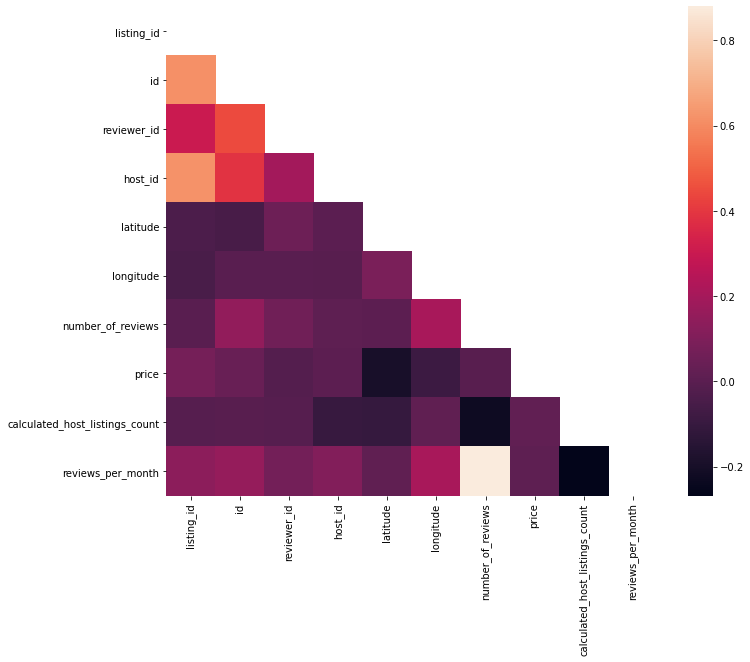

In [ ]:
## Generate a mask for the upper triangle
mask = np.triu(np.ones_like(correlation, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation, mask=mask)

### changing the datatypes of few columns which are not approrpriate

In [ ]:
# Date of Reviews
airbnb['date'] =  pd.to_datetime(airbnb['date'])




In [ ]:
# airbnb['number_of_reviews'] = airbnb['number_of_reviews'].astype('Int64')
# airbnb['number_of_reviews'].dtype


In [ ]:
# changing data type for categorical variables
airbnb['room_type']=airbnb['room_type'].astype('category')
airbnb['room_type'].dtype

CategoricalDtype(categories=['Entire home/apt', 'Private room', 'Shared room'], ordered=False)

In [ ]:
airbnb['neighbourhood']=airbnb['neighbourhood'].astype('category')
airbnb['neighbourhood'].dtype

CategoricalDtype(categories=['Ang Mo Kio', 'Bedok', 'Bishan', 'Bukit Batok',
                  'Bukit Merah', 'Bukit Panjang', 'Bukit Timah',
                  'Central Water Catchment', 'Choa Chu Kang', 'Clementi',
                  'Downtown Core', 'Geylang', 'Hougang', 'Jurong East',
                  'Jurong West', 'Kallang', 'Mandai', 'Marina South',
                  'Marine Parade', 'Museum', 'Newton', 'Novena', 'Orchard',
                  'Outram', 'Pasir Ris', 'Punggol', 'Queenstown',
                  'River Valley', 'Rochor', 'Sembawang', 'Sengkang',
                  'Serangoon', 'Singapore River', 'Southern Islands',
                  'Sungei Kadut', 'Tampines', 'Tanglin', 'Toa Payoh', 'Tuas',
                  'Western Water Catchment', 'Woodlands', 'Yishun'],
                 ordered=False)

In [ ]:
airbnb['neighbourhood_group']=airbnb['neighbourhood_group'].astype('category')
airbnb['neighbourhood_group'].dtype

CategoricalDtype(categories=['Central Region', 'East Region', 'North Region',
                  'North-East Region', 'West Region'],
                 ordered=False)

In [ ]:
airbnb.dtypes

listing_id                                 int64
id                                         int64
date                              datetime64[ns]
reviewer_id                                int64
reviewer_name                             object
comments                                  object
neighbourhood_group                     category
neighbourhood                           category
host_id                                    int64
latitude                                 float64
longitude                                float64
number_of_reviews                          int64
room_type                               category
host_name                                 object
host_is_superhost                         object
price                                      int64
calculated_host_listings_count             int64
reviews_per_month                        float64
name                                      object
dtype: object

### Datatypes have been changed Now we will check for missing values

In [ ]:
print("The columns with missing values are",airbnb.columns[airbnb.isnull().any()].tolist())

The columns with missing values are ['reviewer_name', 'comments', 'host_name', 'host_is_superhost', 'name']


In [ ]:
#We are dropping reviewer name as we don't need it for future analysis
airbnb.drop(['reviewer_name'], axis=1,inplace=True)

In [ ]:
total_missing_value_dataset=airbnb.isnull().sum().sum()
print("The total missing values in the dataset are ",total_missing_value_dataset)

The total missing values in the dataset are  5213


## Working on Missing Values

In [ ]:
# dropping missing values for 
airbnb = airbnb.dropna( how='any',
                    subset=['host_is_superhost','name'])

In [ ]:
#checking if still there is null value
airbnb['host_is_superhost'].isnull().any()

False

In [ ]:
# For comments we are using mode or most frequent imputation

most_freq=airbnb['comments'].value_counts().idxmax()  #gives most frequent used value
most_freq

'Good'

In [ ]:
airbnb['comments'].replace(np.nan,most_freq, inplace=True)

In [ ]:
#checking if still there is a null value
airbnb['comments'].isnull().any()

False

In [ ]:
#as host_name is a categorical value we are removing the missing value with most frequent value
most_freq=airbnb['host_name'].value_counts().idxmax()  #gives most frequent used value
most_freq

'Alex'

In [ ]:
airbnb['host_name'].replace(np.nan,most_freq, inplace=True)

In [ ]:
#checking if still there is a null value
airbnb['comments'].isnull().any()

False

In [ ]:
airbnb.isnull().any()

listing_id                        False
id                                False
date                              False
reviewer_id                       False
comments                          False
neighbourhood_group               False
neighbourhood                     False
host_id                           False
latitude                          False
longitude                         False
number_of_reviews                 False
room_type                         False
host_name                         False
host_is_superhost                 False
price                             False
calculated_host_listings_count    False
reviews_per_month                 False
name                              False
dtype: bool

### So, Now there are no more missing values After next step is Looking for Outliers


Function used in Looking for the Outliers

In [ ]:
def outliers_number(mySeries, upperOutlier, lowerOutlier):
    return sum((mySeries > upperOutlier.loc[mySeries.name, ]) | (mySeries < lowerOutlier.loc[mySeries.name,]))



In [ ]:
def statistics_outlier(df):
    numericalDescribe = (df.describe().T).round(decimals=3) #transpose the rows to column of the out of decribe()
    
    # Calculate outliers using this formula: first quartile – 1.5·IQR > outlier > third quartile + 1.5·IQR
    numericalDescribe['IQR'] = numericalDescribe['75%'] - numericalDescribe['25%']
    numericalDescribe['outliers'] = (numericalDescribe['max'] > (numericalDescribe['75%'] + (1.5 * numericalDescribe['IQR']))) \
                            | (numericalDescribe['min'] < (numericalDescribe['25%'] - (1.5 * numericalDescribe['IQR'])))
    
    
    #This part will give number of outliers (optional)
    # Calculate IQR for each column of the dataframe.
    IQR = df.quantile(.75) - df.quantile(.25)
    
    # Calculate the upper and lower outlier values
    upperOutlier = df.quantile(.75) + (1.5 * (IQR))
    lowerOutlier = df.quantile(.25) - (1.5 * (IQR))
    
    # Store the result in a new column
    numericalDescribe['num_outliers'] = df.apply(outliers_number, args=(upperOutlier, lowerOutlier))
    numericalDescribe.sort_values('num_outliers', ascending=False, inplace=True)

    return numericalDescribe

In [ ]:
df_airbnb=airbnb.copy()
df_airbnb=df_airbnb.select_dtypes(include=np.number)

In [ ]:
# convert all these to float64
df_airbnb = df_airbnb.astype(float)

stats_df=statistics_outlier(df_airbnb)
stats_df

,count,mean,std,min,25%,50%,75%,max,IQR,outliers,num_outliers
calculated_host_listings_count,98349.0,1.578900e+01,3.229100e+01,1.000,2.000000e+00,6.000000e+00,1.400000e+01,2.770000e+02,1.200000e+01,True,11312
latitude,98349.0,1.313000e+00,2.800000e-02,1.244,1.297000e+00,1.311000e+00,1.318000e+00,1.452000e+00,2.100000e-02,True,8886
longitude,98349.0,1.038580e+02,4.200000e-02,103.647,1.038400e+02,1.038530e+02,1.038830e+02,1.039730e+02,4.300000e-02,True,8410
host_id,98349.0,5.614670e+07,5.770082e+07,23666.000,1.432654e+07,3.309627e+07,8.057004e+07,2.690928e+08,6.624349e+07,True,5972
price,98349.0,1.344510e+02,1.471640e+02,0.000,6.000000e+01,1.020000e+02,1.710000e+02,1.000000e+04,1.110000e+02,True,5059
number_of_reviews,98349.0,2.779300e+01,2.368800e+01,0.000,7.000000e+00,2.400000e+01,4.200000e+01,1.560000e+02,3.500000e+01,True,718
reviews_per_month,98349.0,2.536000e+00,1.770000e+00,0.010,1.100000e+00,2.210000e+00,3.710000e+00,1.209000e+01,2.610000e+00,True,451
listing_id,98349.0,1.488093e+07,8.446430e+06,49091.000,7.843168e+06,1.451550e+07,2.126635e+07,3.598540e+07,1.342318e+07,False,0
id,98349.0,2.536725e+08,1.313269e+08,251467.000,1.416259e+08,2.519838e+08,3.586075e+08,4.760517e+08,2.169815e+08,False,0
reviewer_id,98349.0,8.693569e+07,6.990658e+07,277.000,2.795075e+07,6.643108e+07,1.353484e+08,2.704315e+08,1.073976e+08,False,0


 Necessarily all outliers are not be removed as removing ouliers from host id will remove some of the potential hosts as it is 
    unique to hosts. Moving forward we will remove outliers only from Price, reviews_per_month and calculated hosts listing as it can
    influence our analysis.


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Distribution of Price')

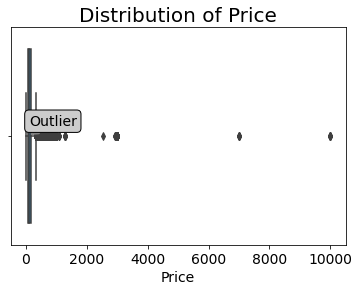

In [ ]:
# box plot of the variable price
ax = sns.boxplot(airbnb.price)

# notation indicating an outlier
ax.annotate('Outlier', xy=(105,0), xytext=(98,-0.05), fontsize=14,
            arrowprops=dict(arrowstyle='->', ec='grey', lw=2), bbox = dict(boxstyle="round", fc="0.8"))

# xtick, label, and title
plt.xticks(fontsize=14)
plt.xlabel('Price', fontsize=14)
plt.title('Distribution of Price', fontsize=20)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Distribution of Reviews')

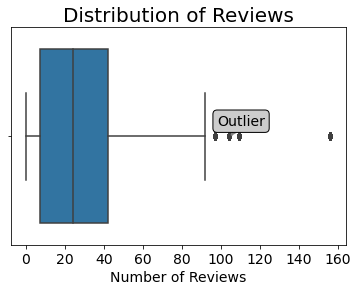

In [ ]:
# box plot of the variable price
ax = sns.boxplot(airbnb.number_of_reviews)

# notation indicating an outlier
ax.annotate('Outlier', xy=(105,0), xytext=(98,-0.05), fontsize=14,
            arrowprops=dict(arrowstyle='->', ec='grey', lw=2), bbox = dict(boxstyle="round", fc="0.8"))

# xtick, label, and title
plt.xticks(fontsize=14)
plt.xlabel('Number of Reviews', fontsize=14)
plt.title('Distribution of Reviews', fontsize=20)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Distribution of Listings')

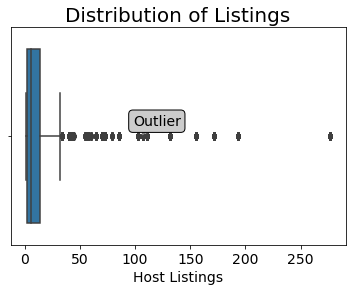

In [ ]:
# box plot of the variable price
ax = sns.boxplot(airbnb.calculated_host_listings_count)

# notation indicating an outlier
ax.annotate('Outlier', xy=(105,0), xytext=(98,-0.05), fontsize=14,
            arrowprops=dict(arrowstyle='->', ec='grey', lw=2), bbox = dict(boxstyle="round", fc="0.8"))

# xtick, label, and title
plt.xticks(fontsize=14)
plt.xlabel('Host Listings', fontsize=14)
plt.title('Distribution of Listings', fontsize=20)


### Outliers for price is removed using IQR method as this method is used mostly for skewed distribution.
Reference:https://www.analyticsvidhya.com/blog/2021/05/feature-engineering-how-to-detect-and-remove-outliers-with-python-code/

In [ ]:
#Calculate IQR for each column of the dataframe.
IQR = airbnb['price'].quantile(.75) - airbnb['price'].quantile(.25)

    
    # Calculate the upper and lower outlier values
maximum= airbnb['price'].quantile(.75) + (1.5 * (IQR))
minimum = airbnb['price'].quantile(.25) - (1.5 * (IQR))
    
    
airbnb = airbnb[(df_airbnb['price'] > minimum) & (airbnb['price'] < maximum)]


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Distribution of Price')

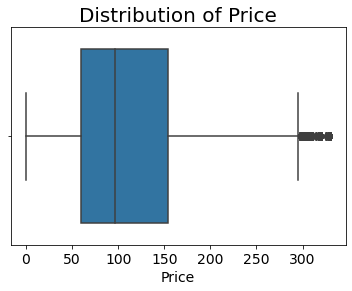

In [ ]:
# box plot of the variable price
ax = sns.boxplot(airbnb.price)


# xtick, label, and title
plt.xticks(fontsize=14)
plt.xlabel('Price', fontsize=14)
plt.title('Distribution of Price', fontsize=20)

 Outliers from the price are removed to an extent now.

In [ ]:
#Calculate IQR for each column of the dataframe.
IQR = airbnb['calculated_host_listings_count'].quantile(.75) - airbnb['calculated_host_listings_count'].quantile(.25)

    
    # Calculate the upper and lower outlier values
maximum= airbnb['calculated_host_listings_count'].quantile(.75) + (1.5 * (IQR))
minimum = airbnb['calculated_host_listings_count'].quantile(.25) - (1.5 * (IQR))
    
    
airbnb = airbnb[(df_airbnb['calculated_host_listings_count'] > minimum) & (airbnb['calculated_host_listings_count'] < maximum)]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Distribution of Listings')

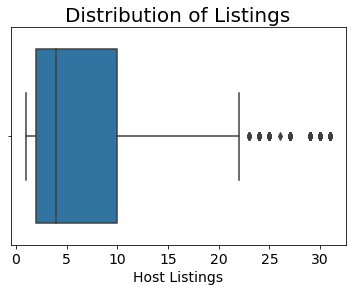

In [ ]:
# box plot of the variable price
ax = sns.boxplot(airbnb.calculated_host_listings_count)


# xtick, label, and title
plt.xticks(fontsize=14)
plt.xlabel('Host Listings', fontsize=14)
plt.title('Distribution of Listings', fontsize=20)


## Transformation of DATA

## Checking For Skewness

If the skewness is between -0.5 and 0.5, the data are fairly symmetrical
- If the skewness is between -1 and — 0.5 or between 0.5 and 1, the data are moderately skewed
- If the skewness is less than -1 or greater than 1, the data are highly skewed

In [ ]:
airbnb.skew(axis = 0)

listing_id                        0.236914
id                               -0.040155
reviewer_id                       0.709459
host_id                           1.284639
latitude                          1.665223
longitude                        -0.280727
number_of_reviews                 0.991281
price                             0.927329
calculated_host_listings_count    1.538526
reviews_per_month                 0.856471
dtype: float64

Skewness of the Columns like listing_id, id, reviewer_id,host_id, latitude and longitude doesn't effect the analysis. So we will transform columns like number of reviews and calculated_host_listings which also has outliers

In [ ]:
airbnb['calculated_host_listings_count']=np.log(airbnb['calculated_host_listings_count'])
airbnb['calculated_host_listings_count'].skew()


0.06864636181396779

Using the functions created above, we will check for the outliers again. which now says that outliers are removed to an extent now

In [ ]:
df_airbnb=airbnb.copy()
df_airbnb=df_airbnb.select_dtypes(include=np.number)

In [ ]:
# convert all these to float64
df_airbnb = df_airbnb.astype(float)

stats_df=statistics_outlier(df_airbnb)
stats_df

,count,mean,std,min,25%,50%,75%,max,IQR,outliers,num_outliers
longitude,82166.0,1.038580e+02,4.400000e-02,103.665,1.038400e+02,1.038540e+02,1.038840e+02,1.039730e+02,4.400000e-02,True,7572
latitude,82166.0,1.316000e+00,3.000000e-02,1.245,1.299000e+00,1.312000e+00,1.321000e+00,1.452000e+00,2.200000e-02,True,7554
host_id,82166.0,5.922076e+07,5.807191e+07,23666.000,1.703296e+07,4.035346e+07,9.061392e+07,2.690928e+08,7.358096e+07,True,2848
price,82166.0,1.148190e+02,7.130800e+01,0.000,5.800000e+01,9.500000e+01,1.540000e+02,3.300000e+02,9.600000e+01,True,1398
number_of_reviews,82166.0,2.874000e+01,2.395600e+01,0.000,8.000000e+00,2.500000e+01,4.300000e+01,1.560000e+02,3.500000e+01,True,718
reviews_per_month,82166.0,2.649000e+00,1.777000e+00,0.010,1.220000e+00,2.400000e+00,3.840000e+00,1.209000e+01,2.620000e+00,True,451
listing_id,82166.0,1.504576e+07,8.251213e+06,49091.000,8.200542e+06,1.479118e+07,2.126635e+07,3.598540e+07,1.306581e+07,False,0
id,82166.0,2.539457e+08,1.296661e+08,251467.000,1.441469e+08,2.510286e+08,3.573628e+08,4.760517e+08,2.132159e+08,False,0
reviewer_id,82166.0,8.737349e+07,6.972431e+07,277.000,2.850295e+07,6.741262e+07,1.360040e+08,2.704315e+08,1.075011e+08,False,0
calculated_host_listings_count,82166.0,1.426000e+00,1.068000e+00,0.000,6.930000e-01,1.386000e+00,2.303000e+00,3.434000e+00,1.610000e+00,False,0


## Binning the Price Variable to have better insight

We would like 3 bins of equal size bandwidth so we use numpy's linspace(start_value, end_value, numbers_generated function. We need to set the start_value of the function to be the min(airbnb["price"]), the end_value to be the max(airbnb["price"]).We also need to set the number of bins needed. 

In [ ]:
bins = np.linspace(min(airbnb["price"]), max(airbnb["price"]), 4)
bins
#group names:
group_names = ['Low', 'Medium', 'High']
#We apply the function "cut" the determine what each value of "df['horsepower']" belongs to.
airbnb['price_range'] = pd.cut(airbnb['price'], bins, labels=group_names, include_lowest=True )
airbnb[['price','price_range']].head(100)

,price,price_range
0,81,Low
1,80,Low
2,80,Low
3,80,Low
4,80,Low
...,...,...
95,102,Low
96,102,Low
97,102,Low
98,102,Low


# Visualization

## 1. Which Region has the most number of listings?

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


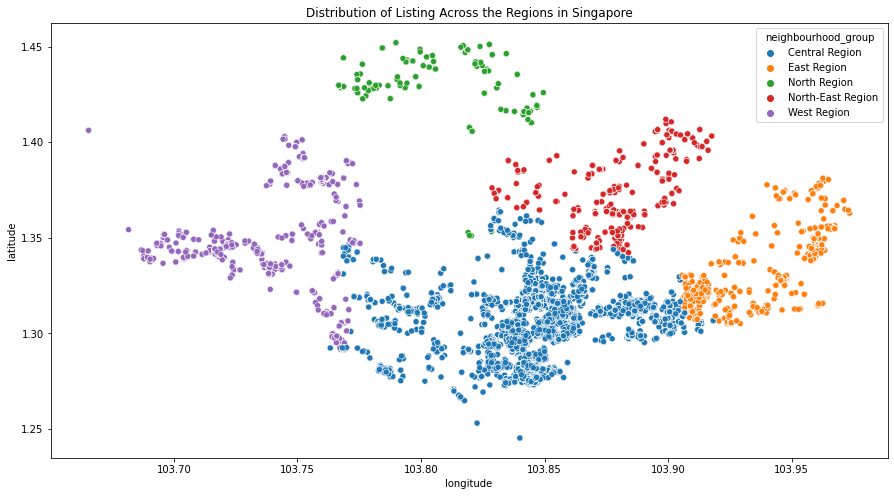

In [ ]:
plt.figure(figsize=(15,8))
sns.scatterplot(airbnb.longitude,airbnb.latitude,hue=airbnb.neighbourhood_group).set(title='Distribution of Listing Across the Regions in Singapore')
plt.ioff()

## Interpretation:

### The Central region has most number of listings.The North Region has the lowest number of listing.

# Price

## 2. What is the distribution of Price across the Regions? or Which is the expensive region?

In [ ]:
airbnb1 = airbnb.groupby(['neighbourhood_group','price_range']).agg({'listing_id':['count']})
airbnb1.head(5)

listing_id
                                     count
neighbourhood_group price_range           
Central Region      Low              32310
                    Medium           22475
                    High              8341
East Region         Low               6969
                    Medium            2329

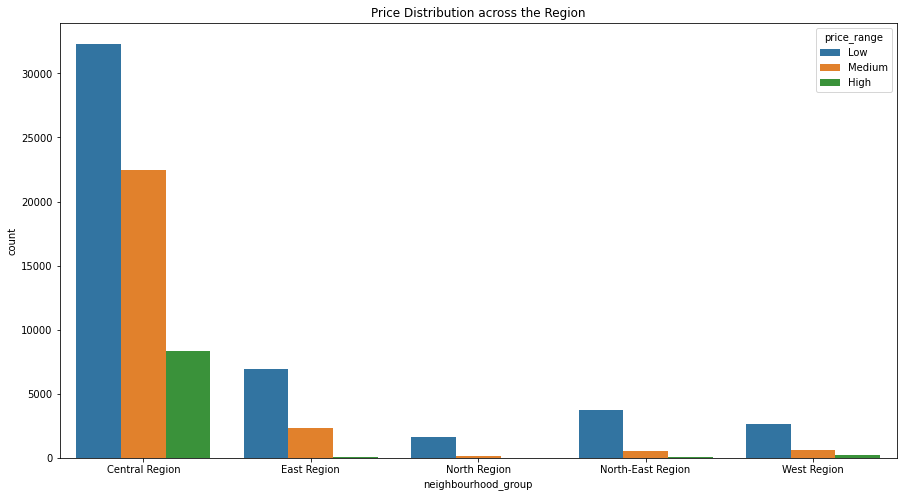

In [ ]:
plt.figure(figsize=(15,8))
sns.countplot(x = "neighbourhood_group",hue = 'price_range',data = airbnb)
plt.title("Price Distribution across the Region")
plt.show()

## Interpretation:

### The Central Region has more expensive listings than any other Region. All regions including the Central Region have cheap listings, with the North Region being the cheapest. One reason why Central Region has most expensive listings  is because most listings are in the Central Region.

## 3. Percentage of different Room Types

In [ ]:
import plotly.offline as pyo
import plotly.graph_objs as go

airbnb1= airbnb.groupby(['room_type']).size()/airbnb['room_type'].count()*100
labels = airbnb1.index
values = airbnb1.values

# Use `hole` to create a donut-like pie chart
fig = go.Figure(data=[go.Pie(labels=labels, values=values,hole=0.6)])
fig.show()

## Interpretation:

### From the above pie chart we can say that private rooms are more in demand than other two types of room types.

## 4. What is the Proportion of Room Type for each Region?

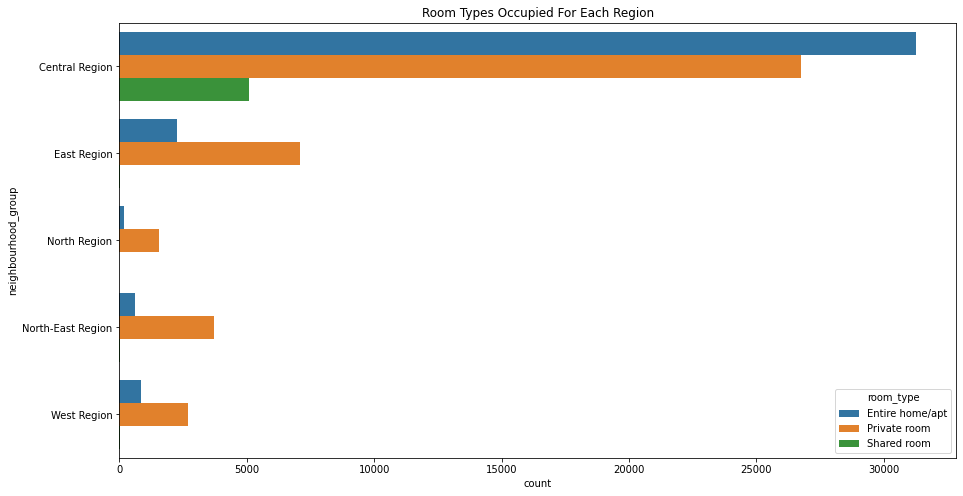

In [ ]:
#countplot plot room types occupied 
plt.figure(figsize=(15,8))
sns.countplot(y="neighbourhood_group", hue="room_type", data=airbnb)
plt.title("Room Types Occupied For Each Region")
plt.show()


## Interpretation:

### We can see the Central Region is the only region that is dominated by the Entire home/apt type accomodation, with the rest of the region is dominated by Private rooms. 

## 5. Room Types and the price

[Text(0.5, 1.0, 'Price Distribution of different Room Types')]

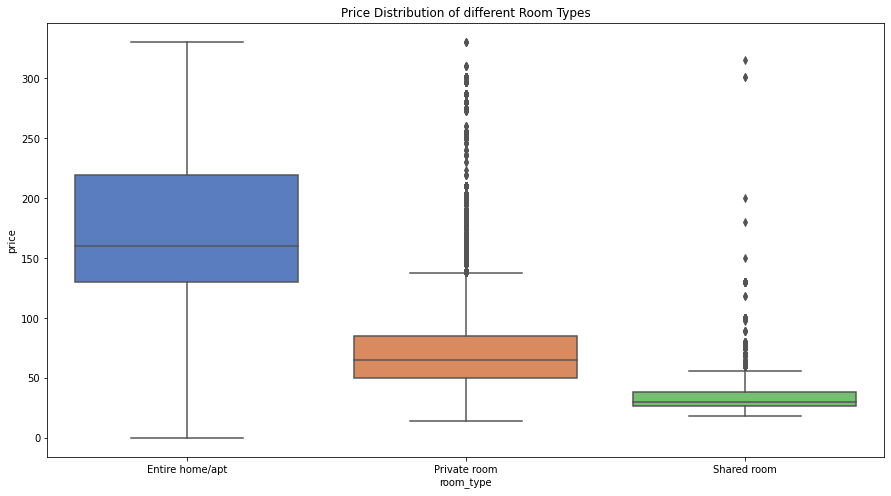

In [ ]:
#boxplot room type and price
plt.figure(figsize=(15,8))
sns.boxplot(x="room_type", y="price",
                    data=airbnb, palette="muted").set(title='Price Distribution of different Room Types')

## Interpretation:

### From the above box plots we can deduce that the Entire home/apt category is more expensive than other room types. The Entire home/apt category has more symmetrically distributed price with no outliers. Since price cannot go below zero, all outliers recorded are on the up side. 

# Reviews

## 6. Room with Most number of Reviews

In [ ]:
#just using top 1000 rows
airbnb_reviews=airbnb.sort_values(by=['number_of_reviews'],ascending=False).head(1000)
airbnb_reviews.head()

,listing_id,id,date,reviewer_id,comments,neighbourhood_group,neighbourhood,host_id,latitude,longitude,number_of_reviews,room_type,host_name,host_is_superhost,price,calculated_host_listings_count,reviews_per_month,name,price_range
77961,21509015,275427112,2018-11-06,149576712,The place is spectacular. Easily accessible si...,East Region,Pasir Ris,156290352,1.36287,103.97342,156,Private room,Su,f,85,0.693147,12.09,Close to Changi Airport/Biz Park/Expo(S),Low
77936,21509015,254200764,2018-04-16,10923739,Su's place is only 10-15 minutes taxi/Uber dri...,East Region,Pasir Ris,156290352,1.36287,103.97342,156,Private room,Su,f,85,0.693147,12.09,Close to Changi Airport/Biz Park/Expo(S),Low
77934,21509015,253274884,2018-04-14,182476243,SU 아주머니가 쉬운 영어로 천천히 응대를 잘 해줘서 편했습니다. 합리적인 가격으로...,East Region,Pasir Ris,156290352,1.36287,103.97342,156,Private room,Su,f,85,0.693147,12.09,Close to Changi Airport/Biz Park/Expo(S),Low
77933,21509015,252988384,2018-04-13,35634866,Su's place was very nice and spacious. Close t...,East Region,Pasir Ris,156290352,1.36287,103.97342,156,Private room,Su,f,85,0.693147,12.09,Close to Changi Airport/Biz Park/Expo(S),Low
77932,21509015,251390220,2018-08-04,181400995,The host was extremely accommodating and the t...,East Region,Pasir Ris,156290352,1.36287,103.97342,156,Private room,Su,f,85,0.693147,12.09,Close to Changi Airport/Biz Park/Expo(S),Low


In [ ]:
import folium
from folium.plugins import MarkerCluster
from folium import plugins
print("Rooms with the most number of reviews")
Long = 103.91492
Lat = 1.32122
mapdf1 = folium.Map([Lat, Long], zoom_start=13)
mapdf1_rooms_map=plugins.MarkerCluster().add_to(mapdf1)

for lat,lon, label in zip(airbnb_reviews.latitude,airbnb_reviews.longitude,airbnb_reviews.name):
    folium.Marker(location=[lat,lon],icon=folium.Icon(icon='home'),popup=label).add_to(mapdf1_rooms_map)
mapdf1.add_child(mapdf1_rooms_map)

mapdf1

Rooms with the most number of reviews


## Demand


Since we did not have data on the bookings made over the past year, we will use 'number of reviews' variable as the indicator for demand in order to study it. Approximately 50% of guests review the hosts/listings on Airbnb, hence studying the number of reviews will give us a good indication of the demand.

## How popular is Airbnb in Singapore?

In [ ]:
airbnb['year'] =airbnb['date'].dt.year #extracting year

In [ ]:
reviews_num=airbnb.groupby('year').agg({'listing_id':['count']}) #counting unique listings over the time

In [ ]:
reviews_num

,listing_id
,count
year,
2011,25
2012,156
2013,388
2014,965
2015,4003
2016,10629
2017,18443
2018,28950


Text(0, 0.5, 'Unique listing recieving reviews')

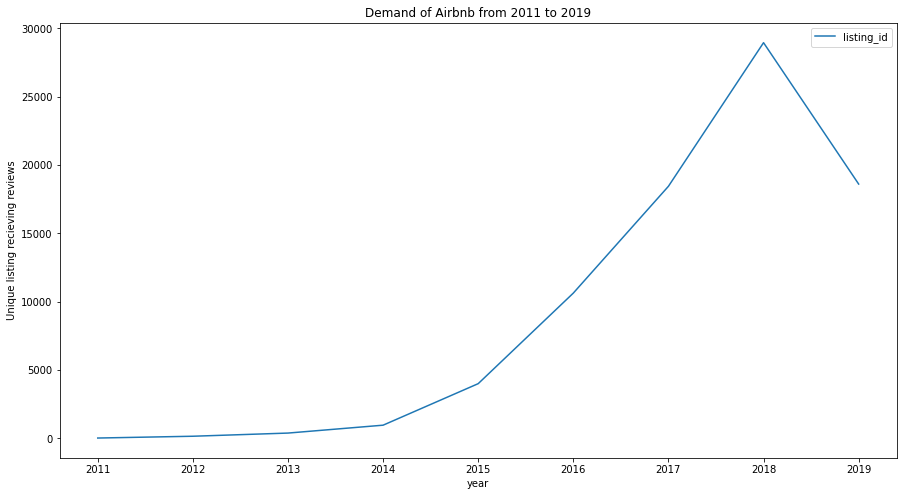

In [ ]:
plt.figure(figsize=(15,8))
ax=sns.lineplot(data=reviews_num).set(title='Demand of Airbnb from 2011 to 2019')

plt.ylabel('Unique listing recieving reviews')


## Interpretation:

The number of unique listings receiving reviews has increased over the years. We can see an almost exponential increase in the number of reviews, which as discussed earlier, indicates an exponential increase in the demand.


## Price Over period of time

In [ ]:
airbnb['month'] =airbnb['date'].dt.month

In [ ]:
price=airbnb.groupby('year').agg({'price':['mean']}) #calculating average price

In [ ]:
price=round(price,2)

Text(0, 0.5, 'Average Price')

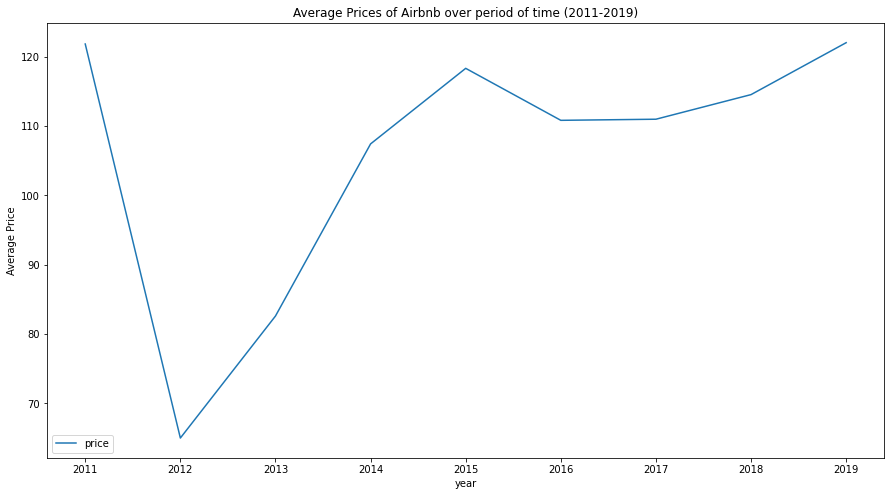

In [ ]:
plt.figure(figsize=(15,8))
ax=sns.lineplot(data=price).set(title='Average Prices of Airbnb over period of time (2011-2019)')
plt.ylabel('Average Price')


## Interpretation:

The average prices across listings tends to be unsteady over the years, in 2012 it saw a dip and then there was increase till the year 2015 and slight dip in 2016 and then we see consequent increase in last three years

## Textual Analysis

In [ ]:
airbnb['comments']=airbnb['comments'].str.lower() #converts the comment column to lower case


## What languages are comments written?


In [ ]:
def language_detection(text): #Function written to detect language
    try:
        return detect(text)
    except:
        return None

In [ ]:
#Due to extensive run time this is commented out and result is merged with the existing dataset
# airbnb['language'] = airbnb['comments'].apply(language_detection)


In [ ]:
# #write the dataframe to a csv file in order to avoid the long runtime

#airbnb.to_csv('/content/drive/MyDrive/Dataset/new_airbnb.csv')


In [ ]:
airbnb=pd.read_csv("/content/drive/MyDrive/Dataset/new_airbnb.csv")

[Text(0, 0, 'English'),
 Text(0, 0, 'Chinese'),
 Text(0, 0, 'Korean'),
 Text(0, 0, 'French'),
 Text(0, 0, 'German')]

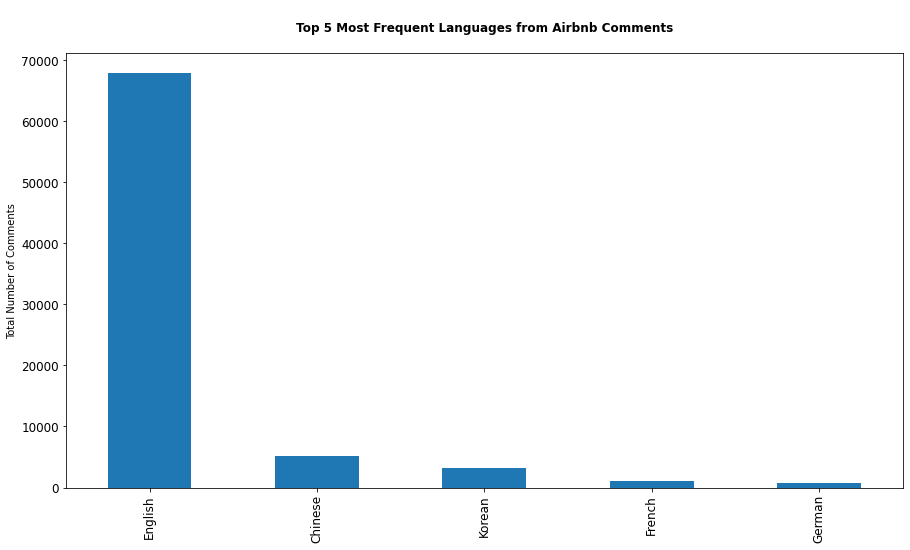

In [ ]:
# visualizing the comments' languages b) neat and clean
ax = airbnb.language.value_counts().head(5).plot(kind='bar', figsize=(15,8),  
                                             fontsize=12);

ax.set_title("\nTop 5 Most Frequent Languages from Airbnb Comments\n", 
             fontsize=12, fontweight='bold')
ax.set_ylabel("Total Number of Comments", fontsize=10)
ax.set_xticklabels(['English', 'Chinese', 'Korean', 'French', 'German'])

## Interpretation:

From the above graph we can see that the majority of comments are written in english, moving forward we will do text analysis only on the reviews written in English.


# Word Cloud For Reviews in English

## Making subset of English Review Dataset

In [ ]:
airbnb_eng = airbnb[(airbnb['language']=='en')]

In [ ]:
airbnb_eng.head(2)

,Unnamed: 0,listing_id,id,date,reviewer_id,comments,neighbourhood_group,neighbourhood,host_id,latitude,longitude,number_of_reviews,room_type,host_name,host_is_superhost,price,calculated_host_listings_count,reviews_per_month,name,price_range,year,month,language
0,0,49091,8243238,2013-10-21,8557223,fran was absolutely gracious and welcoming. ma...,North Region,Woodlands,266763,1.44255,103.79580,0,Private room,Francesca,f,81,0.693147,0.01,COZICOMFORT LONG TERM STAY ROOM 2,Low,2013,10,en
1,1,50646,11909864,2014-04-18,1356099,a comfortable room in a smart condo developmen...,Central Region,Bukit Timah,227796,1.33235,103.78521,0,Private room,Sujatha,f,80,0.000000,0.28,Pleasant Room along Bukit Timah,Low,2014,4,en


In [ ]:
wordcloud = WordCloud(max_font_size=None, max_words=200, background_color="lightgrey",  #creating word cloud
                      width=3000, height=2000,
                      stopwords=stopwords.words('english')).generate(str(airbnb_eng.comments.values))

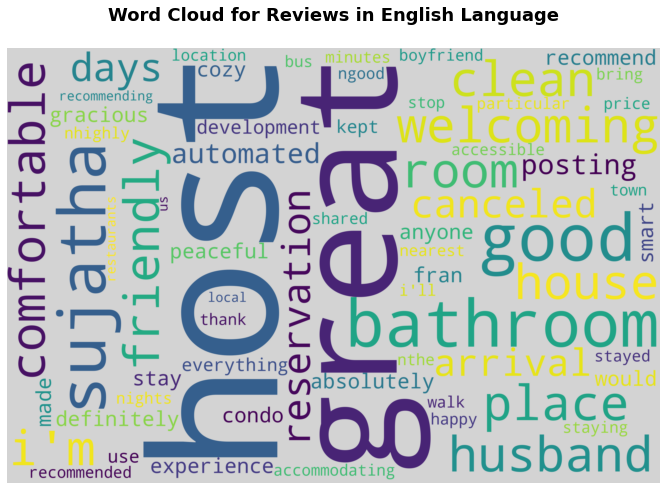

In [ ]:
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.title( 'Word Cloud for Reviews in English Language\n', fontsize=18, fontweight='bold')
plt.show()

# Sentiment Analysis

In [ ]:
#execution of the particular code takes time due to the number of rows
airbnb_eng['subjectivity'] = airbnb_eng['comments'].apply(lambda sub: TextBlob(sub).sentiment.subjectivity) #creates a column with subjectivity of the comment
airbnb_eng.head(2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Unnamed: 0,listing_id,id,date,reviewer_id,comments,neighbourhood_group,neighbourhood,host_id,latitude,longitude,number_of_reviews,room_type,host_name,host_is_superhost,price,calculated_host_listings_count,reviews_per_month,name,price_range,year,month,language,subjectivity
0,0,49091,8243238,2013-10-21,8557223,fran was absolutely gracious and welcoming. ma...,North Region,Woodlands,266763,1.44255,103.79580,0,Private room,Francesca,f,81,0.693147,0.01,COZICOMFORT LONG TERM STAY ROOM 2,Low,2013,10,en,0.680000
1,1,50646,11909864,2014-04-18,1356099,a comfortable room in a smart condo developmen...,Central Region,Bukit Timah,227796,1.33235,103.78521,0,Private room,Sujatha,f,80,0.000000,0.28,Pleasant Room along Bukit Timah,Low,2014,4,en,0.792143


In [ ]:
airbnb_eng['polarity'] = airbnb_eng['comments'].apply(lambda sub: TextBlob(sub).sentiment.polarity) #creates a column with polarity of the comment
airbnb_eng.head(2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Unnamed: 0,listing_id,id,date,reviewer_id,comments,neighbourhood_group,neighbourhood,host_id,latitude,longitude,number_of_reviews,room_type,host_name,host_is_superhost,price,calculated_host_listings_count,reviews_per_month,name,price_range,year,month,language,subjectivity,polarity
0,0,49091,8243238,2013-10-21,8557223,fran was absolutely gracious and welcoming. ma...,North Region,Woodlands,266763,1.44255,103.79580,0,Private room,Francesca,f,81,0.693147,0.01,COZICOMFORT LONG TERM STAY ROOM 2,Low,2013,10,en,0.680000,0.210000
1,1,50646,11909864,2014-04-18,1356099,a comfortable room in a smart condo developmen...,Central Region,Bukit Timah,227796,1.33235,103.78521,0,Private room,Sujatha,f,80,0.000000,0.28,Pleasant Room along Bukit Timah,Low,2014,4,en,0.792143,0.496409


In [ ]:
#function to create categories
def scoring(score):
  if score>0.1:
    return 'Positive'
  elif score <-0.1:
    return 'Negative'
  else:
    return 'Neutral'

In [ ]:
# defining categories based on the polarity score

airbnb_eng['scoring_polarity'] = airbnb_eng['polarity'].apply(scoring)
airbnb_eng.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Unnamed: 0,listing_id,id,date,reviewer_id,comments,neighbourhood_group,neighbourhood,host_id,latitude,longitude,number_of_reviews,room_type,host_name,host_is_superhost,price,calculated_host_listings_count,reviews_per_month,name,price_range,year,month,language,subjectivity,polarity,scoring_polarity
0,0,49091,8243238,2013-10-21,8557223,fran was absolutely gracious and welcoming. ma...,North Region,Woodlands,266763,1.44255,103.79580,0,Private room,Francesca,f,81,0.693147,0.01,COZICOMFORT LONG TERM STAY ROOM 2,Low,2013,10,en,0.680000,0.210000,Positive
1,1,50646,11909864,2014-04-18,1356099,a comfortable room in a smart condo developmen...,Central Region,Bukit Timah,227796,1.33235,103.78521,0,Private room,Sujatha,f,80,0.000000,0.28,Pleasant Room along Bukit Timah,Low,2014,4,en,0.792143,0.496409,Positive
2,2,50646,13823948,2014-05-06,15222393,stayed over at sujatha's house for 3 good nigh...,Central Region,Bukit Timah,227796,1.33235,103.78521,0,Private room,Sujatha,f,80,0.000000,0.28,Pleasant Room along Bukit Timah,Low,2014,5,en,0.586556,0.458889,Positive
3,3,50646,15117222,2014-02-07,5543172,it's been a lovely stay at sujatha's. the room...,Central Region,Bukit Timah,227796,1.33235,103.78521,0,Private room,Sujatha,f,80,0.000000,0.28,Pleasant Room along Bukit Timah,Low,2014,2,en,0.730000,0.573333,Positive
4,4,50646,15426462,2014-08-07,817532,"we had a great experience. a nice place, an am...",Central Region,Bukit Timah,227796,1.33235,103.78521,0,Private room,Sujatha,f,80,0.000000,0.28,Pleasant Room along Bukit Timah,Low,2014,8,en,0.658333,0.355556,Positive


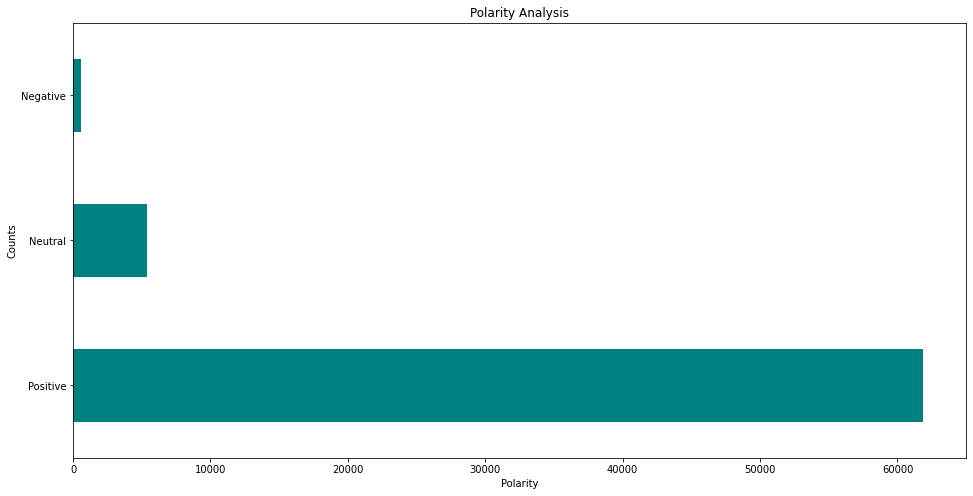

In [ ]:
# Show the value counts
plt.subplots(figsize = (16,8))
airbnb_eng['scoring_polarity'].value_counts()

# Plot and visualize the counts:
plt.title('Polarity Analysis')
plt.xlabel('Polarity')
plt.ylabel('Counts')

airbnb_eng['scoring_polarity'].value_counts().plot(kind = 'barh', color = 'teal')
plt.show()

## Interpretation:


According the above graph, most of the reviews written by customers are positive.

## Conclusion

By performing different analysis on the dataset, we have 
identified various new insights on how Airbnb listings are distributed on Singapore. 

We have identified where the listings are located, found out which Region is dominating the number of listings, the price range distribution, and the demand in different room types in each region.

We conclude from our analysis that the Central Region is understandably dominating the listings on Airbnb in a number of ways. Most of the Central Region area is where the tourism district is located; popular neighbourhoods in the Central Region include the Singapore River, Marina Parade, Newton, Rochor, Novena, Kallang, etc.

Most of the customers are happy customers with positive reviews about the listings.
